# _(Bouchacourt & Buschman, 2019)_ Flexible Working Memory Model

Implementation of :

- Bouchacourt, Flora, and Timothy J. Buschman. "A flexible model of working memory." Neuron 103.1 (2019): 147-160.


In [1]:
import numba
import numpy as np
import brainpy as bp
import matplotlib.pyplot as plt

bp.backend.set('numba')

In [2]:
# increase in order to run multiple trials with the same network
num_trials = 1
num_item_to_load = 6

In [3]:
# Parameters for network architecture
# ------------------------------------

num_sensory_neuron = 512  # Number of recurrent neurons per sensory network
num_sensory_pool = 8  # Number of ring-like sensory network
num_all_sensory = num_sensory_pool * num_sensory_neuron
num_all_random = 1024  # Number of neuron in the random network
fI_slope = 0.4  # slope of the non-linear f-I function
bias = 0.  # bias in the neuron firing response (cf page 1 right column of Burak, Fiete 2012)
tau = 10.  # Synaptic time constant [ms]
init_range = 0.01  # Range to randomly initialize synaptic variables

In [4]:
# Parameters for sensory network
# -------------------------------

k2 = 0.25  # width of negative surround suppression
k1 = 1.  # width of positive amplification
A = 2.  # amplitude of weight function
lambda_ = 0.28  # baseline of weight matrix for recurrent network

In [5]:
# Parameters for interaction of
# random network <-> sensory network
# -----------------------------------

forward_balance = -1.  # if -1, perfect feed-forward balance from SN to RN
backward_balance = -1.  # if -1, perfect feedback balance from RN to SN
alpha = 2.1  # parameter used to compute the feedforward weight, before balancing
beta = 0.2  # parameter used to compute the feedback weight, before balancing
gamma = 0.35  # connectivity (gamma in the paper)
factor = 1000  # factor for computing weights values

In [6]:
# Parameters for stimulus
# -----------------------

simulation_time = 1100  # # the simulation time [ms]
start_stimulation = 100  # [ms]
end_stimulation = 200  # [ms]
input_strength = 10  # strength of the stimulation
num_sensory_input_width = 32
# the width for input stimulation of the gaussian distribution
sigma = round(num_sensory_neuron / num_sensory_input_width)
three_sigma = 3 * sigma
activity_threshold = 3

In [7]:
# Weights initialization
# ----------------------

# weight matrix within sensory network
sensory_encoding = 2. * np.pi * np.arange(1, num_sensory_neuron + 1) / num_sensory_neuron
diff = sensory_encoding.reshape((-1, 1)) - sensory_encoding
weight_mat_of_sensory = lambda_ + A * np.exp(k1 * (np.cos(diff) - 1)) - A * np.exp(k2 * (np.cos(diff) - 1))
diag = np.arange(num_sensory_neuron)
weight_mat_of_sensory[diag, diag] = 0.

In [8]:
# connectivity matrix between sensory and random network
conn_matrix_sensory2random = np.random.rand(num_all_sensory, num_all_random) < gamma

In [9]:
# weight matrix of sensory2random
ws = factor * alpha / conn_matrix_sensory2random.sum(axis=0)
weight_mat_sensory2random = conn_matrix_sensory2random * ws.reshape((1, -1))
ws = weight_mat_sensory2random.sum(axis=0).reshape((1, -1))
weight_mat_sensory2random += forward_balance / num_all_sensory * ws  # balance

In [10]:
# weight matrix of random2sensory
ws = factor * beta / conn_matrix_sensory2random.sum(axis=1)
weight_mat_random2sensory = conn_matrix_sensory2random.T * ws.reshape((1, -1))
ws = weight_mat_random2sensory.sum(axis=0).reshape((1, -1))
weight_mat_random2sensory += backward_balance / num_all_random * ws  # balance

In [11]:
@numba.njit(['float64[:](float64)'])
def get_input(input_center):
    input = np.zeros(num_sensory_neuron)
    inp_ids = np.arange(int(round(input_center - three_sigma)),
                        int(round(input_center + three_sigma + 1)), 1)
    inp_scale = np.exp(-(inp_ids - input_center) ** 2 / 2 / sigma ** 2) / (np.sqrt(2 * np.pi) * sigma)
    inp_scale /= np.amax(inp_scale)
    inp_ids = np.remainder(inp_ids - 1, num_sensory_neuron)
    input[inp_ids] = input_strength * inp_scale
    input -= np.sum(input) / input.shape[0]
    return input

In [12]:
def get_activity_vector(rates):
    exp_stim_encoding = np.exp(1j * sensory_encoding, dtype=complex)
    timed_abs = np.zeros(num_sensory_pool)
    timed_angle = np.zeros(num_sensory_pool)
    for si in range(num_sensory_pool):
        start = si * num_sensory_neuron
        end = (si + 1) * num_sensory_neuron
        exp_rates = np.multiply(rates[start:end], exp_stim_encoding, dtype=complex)
        mean_rates = np.mean(exp_rates)
        timed_angle[si] = np.angle(mean_rates) * num_sensory_neuron / (2 * np.pi)
        timed_abs[si] = np.absolute(mean_rates)
    timed_angle[timed_angle < 0] += num_sensory_neuron
    return timed_abs, timed_angle

In [13]:
net = bp.Network()

In [14]:
class PoissonNeuron(bp.NeuGroup):
    target_backend = ['numpy', 'numba']

    @staticmethod
    def derivative(s, t):
        ds = -s / tau
        return ds
    
    def __init__(self, size, **kwargs):
        num = bp.size2len(size)

        self.s = bp.ops.zeros(num)
        self.r = bp.ops.zeros(num)
        self.input = bp.ops.zeros(num)
        self.spike = bp.ops.zeros(num, dtype=bool)
        
        self.int_s = bp.odeint(f=self.derivative, method='exponential_euler')

        super(PoissonNeuron, self).__init__(size=size, **kwargs)


    def update(self, _t, _dt):
        self.s = self.int_s(self.s, _t)
        self.r = 0.4 * (1. + np.tanh(fI_slope * (self.input + self.s + bias) - 3.)) / tau
        self.spike = np.random.random(self.s.shape) < self.r * _dt
        self.input[:] = 0.

    def reset(self):
        self.s = np.random.random(self.num) * init_range
        self.r = 0.4 * (1. + np.tanh(fI_slope * (bias + self.s) - 3.)) / tau
        self.input = bp.ops.zeros(self.num)
        self.spike = bp.ops.zeros(self.num, dtype=bool)

In [15]:
sensory_net = PoissonNeuron(num_all_sensory, monitors=['r', 'spike'])
random_net = PoissonNeuron(num_all_random, monitors=['spike'])

net.add(sensory_net, random_net)

In [16]:
class Sen2SenSyn(bp.TwoEndConn):
    target_backend = ['numpy', 'numba']

    def __init__(self, pre, post, **kwargs):
        super(Sen2SenSyn, self).__init__(pre=pre, post=post, **kwargs)

    def update(self):
        for i in range(num_sensory_pool):
            start = i * num_sensory_neuron
            end = (i + 1) * num_sensory_neuron
            for j in range(num_sensory_neuron):
                if self.pre.spike[start + j] > 0.:
                    self.post.s[start: end] += weight_mat_of_sensory[j]


sensory2sensory_conn = Sen2SenSyn(pre=sensory_net, post=sensory_net)

In [17]:
class OtherSyn(bp.TwoEndConn):
    target_backend = ['numpy', 'numba']

    def __init__(self, pre, post, weights, **kwargs):
        self.weights = weights
        super(OtherSyn, self).__init__(pre=pre, post=post, **kwargs)

    def update(self):
        for i in range(self.pre.spike.shape[0]):
            if self.pre.spike[i] > 0.:
                self.post.s += self.weights[i]


random2sensory_conn = OtherSyn(pre=random_net, post=sensory_net,
                               weights=weight_mat_random2sensory)

sensory2random_conn = OtherSyn(pre=sensory_net, post=random_net,
                               weights=weight_mat_sensory2random)

net.add(sensory2sensory_conn, random2sensory_conn, sensory2random_conn)

Load 6 items in trial 0.

Stimulus is given in: [0 1 3 5 6 7]
Memory is found in: [0 1 3 6 7]
5 maintained memories
1 forgotten memories
0 spurious memories



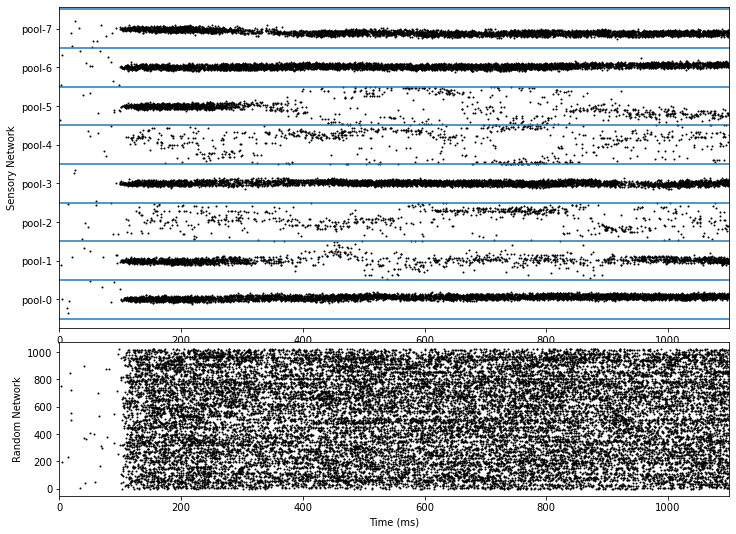

In [18]:
for trial_idx in range(num_trials):
    # inputs
    # ------
    pools_receiving_inputs = np.random.choice(num_sensory_pool, num_item_to_load, replace=False)
    print(f"Load {num_item_to_load} items in trial {trial_idx}.\n")

    input_center = np.ones(num_sensory_pool) * num_sensory_neuron / 2
    inp_vector = np.zeros((num_sensory_pool, num_sensory_neuron))
    for si in pools_receiving_inputs:
        inp_vector[si, :] = get_input(input_center[si])
    inp_vector = inp_vector.flatten()
    Iext, duration = bp.inputs.constant_current([(0., start_stimulation),
                                                 (inp_vector, end_stimulation - start_stimulation),
                                                 (0., simulation_time - end_stimulation)])

    # running
    # -------
    sensory_net.reset()
    random_net.reset()

    net.run(duration, inputs=(sensory_net, 'input', Iext))

    # results
    # --------

    rate_abs, rate_angle = get_activity_vector(sensory_net.mon.r[-1] * 1e3)
    print(f"Stimulus is given in: {np.sort(pools_receiving_inputs)}")
    print(f"Memory is found in: {np.where(rate_abs > activity_threshold)[0]}")

    prob_maintained, prob_spurious = 0, 0
    for si in range(num_sensory_pool):
        if rate_abs[si] > activity_threshold:
            if si in pools_receiving_inputs:
                prob_maintained += 1
            else:
                prob_spurious += 1
    print(str(prob_maintained) + ' maintained memories')
    print(str(pools_receiving_inputs.shape[0] - prob_maintained) + ' forgotten memories')
    print(str(prob_spurious) + ' spurious memories\n')
    prob_maintained /= float(num_item_to_load)
    if num_item_to_load != num_sensory_pool:
        prob_spurious /= float(num_sensory_pool - num_item_to_load)

    # visualization
    # -------------
    fig, gs = bp.visualize.get_figure(6, 1, 1.5, 12)

    fig.add_subplot(gs[0:4, 0])
    xlim = (net.t_start, net.t_end)
    bp.visualize.raster_plot(net.ts, sensory_net.mon.spike, ylabel='Sensory Network', xlim=xlim)
    for index_sn in range(num_sensory_pool + 1):
        plt.axhline(index_sn * num_sensory_neuron)
    plt.yticks([num_sensory_neuron * (i + 0.5) for i in range(num_sensory_pool)],
               [f'pool-{i}' for i in range(num_sensory_pool)])

    fig.add_subplot(gs[4:6, 0])
    bp.visualize.raster_plot(net.ts, random_net.mon.spike, ylabel='Random Network', xlim=xlim, show=True)